## Loading the Dataset

In [6]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory


In [7]:
!kaggle datasets download -d joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20

Dataset URL: https://www.kaggle.com/datasets/joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
mpox-skin-lesion-dataset-version-20-msld-v20.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
import zipfile
zip_ref = zipfile.ZipFile('/content/mpox-skin-lesion-dataset-version-20-msld-v20.zip','r')
zip_ref.extractall ('/content')
zip_ref.close()

## Importing Libraries

In [9]:
#Importing all the required libraries

!pip install innvestigate
import innvestigate
import pandas as pd
#for Math operations
import numpy as np
#Machine learning libraries
import os
from random import shuffle
import random
#for opening and loading images
!pip install opencv-python
import cv2
# for Preprocessing
from tensorflow.keras.preprocessing import image
#for visualization
import plotly.express as px
import matplotlib.pyplot as plt
#convert class labels to one-hot encoded vectors
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from keras.optimizers import Adam

from numpy import loadtxt

from sklearn.metrics import confusion_matrix


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pre-processing the dataset

In [11]:
train_folder = "/content/Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train"
val_folder = "/content/Original Images/Original Images/FOLDS/fold5/Valid"
test_folder = "/content/Original Images/Original Images/FOLDS/fold5/Test"

In [12]:
BATCH_SIZE = 16
# Data augmentation
BATCH_SIZE = 16
train_datagen = ImageDataGenerator(
    rescale=1./255,                       # Normalization done to rescale the pixel values of the images to a range of [0, 1] by dividing by 255
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_data = train_datagen.flow_from_directory(directory=train_folder, target_size=(224,224),batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=42)

val_gen = ImageDataGenerator(rescale=1./255)
val_data = val_gen.flow_from_directory(directory=val_folder, target_size=(224,224),batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=42)

test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(directory=test_folder, target_size=(224,224),batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False, seed = 42)
train_data.class_indices

Found 7532 images belonging to 6 classes.
Found 154 images belonging to 6 classes.
Found 63 images belonging to 6 classes.


{'Chickenpox': 0,
 'Cowpox': 1,
 'HFMD': 2,
 'Healthy': 3,
 'Measles': 4,
 'Monkeypox': 5}

In [13]:
x,y = next(train_data)
x.shape

(16, 224, 224, 3)

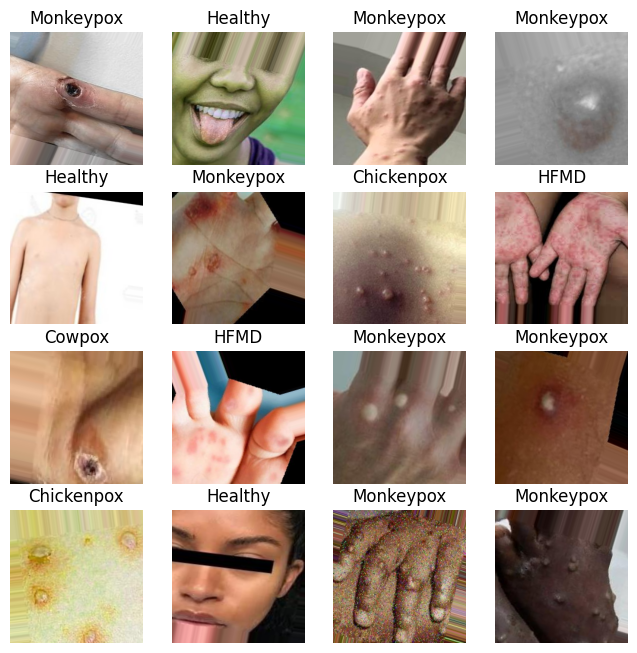

In [14]:
# OR we can display simply by
a = train_data.class_indices
class_names = list(a.keys())  # storing class/breed names in a list


def plot_images(img, labels):
    plt.figure(figsize=[8, 10])
    for i in range(len(img)):
        plt.subplot(5, 4, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()
plot_images(x,y)

In [15]:
def class_distrubution(folder):
  # Calculate class distribution
  class_names = os.listdir(folder)
  class_dis = [len(os.listdir(folder + "/" + name)) for name in class_names]
  fig = px.pie(names=class_names, values=class_dis, title="Class Distribution")
  fig.update_layout(title_x = 0.47)
  fig.show()
  print(class_names, class_dis)


In [16]:
class_distrubution(train_folder)
#class_distrubution(val_folder)

['Monkeypox', 'HFMD', 'Cowpox', 'Chickenpox', 'Measles', 'Healthy'] [2968, 1526, 602, 742, 532, 1162]


We can clearly see the class imbalance here which will be resolved using SMOTE.

## Applying Oversampling Technique : SMOTE

Applying **SMOTE** to the entire dataset

Resampled class distribution: Counter({0: 2968, 1: 2968, 2: 2968, 3: 2968, 4: 2968, 5: 2968})


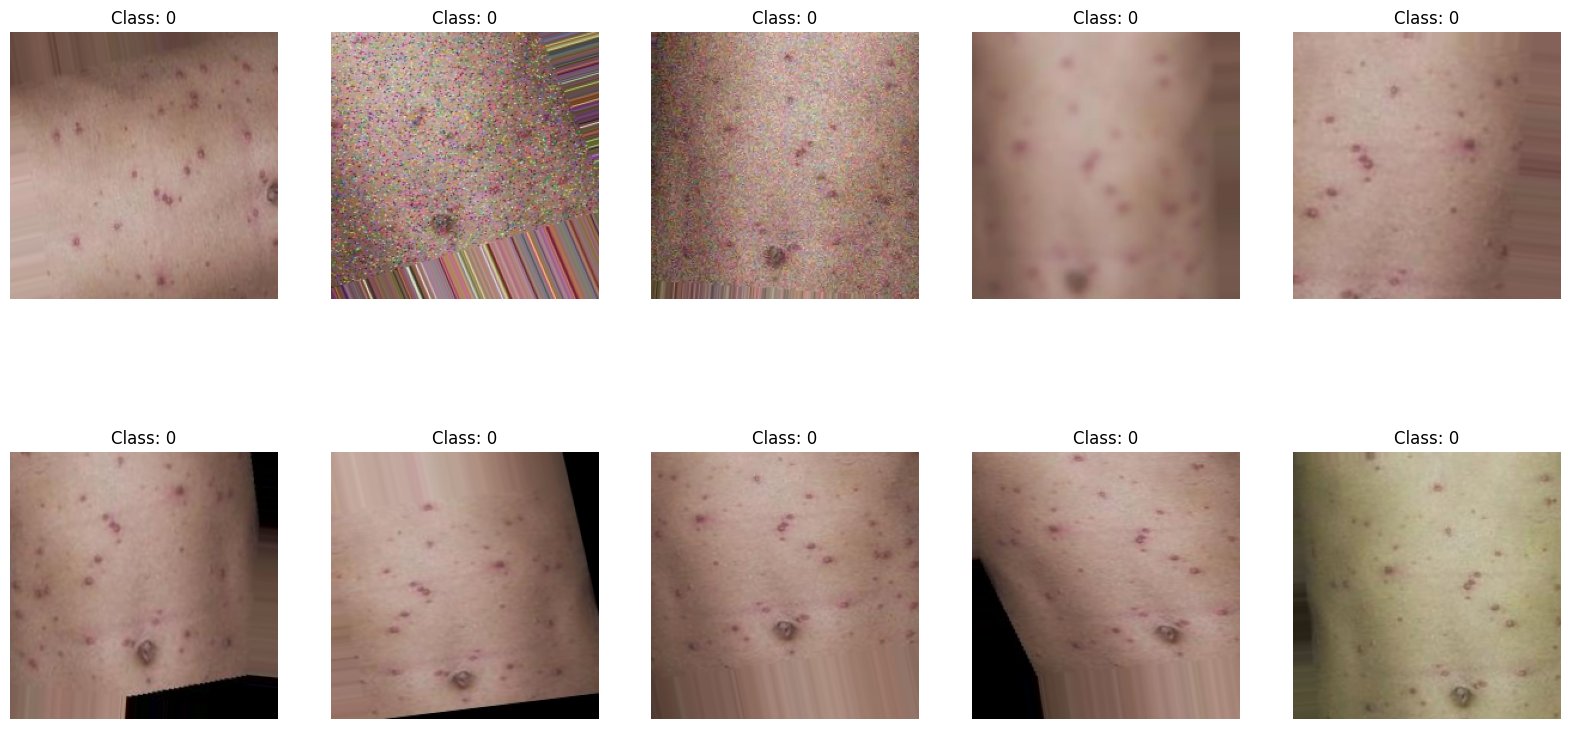

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from keras.utils import to_categorical
from collections import Counter
import matplotlib.pyplot as plt

# Load and preprocess the entire dataset
def load_and_preprocess_images(image_paths, target_size):
    images = []
    for filepath in image_paths:
        image = cv2.imread(filepath)
        image = cv2.resize(image, target_size)
        image = image / 255.0  # Normalize image
        images.append(image)
    return np.array(images, dtype=np.float32)

# Assuming train_image_paths and train_labels are available
target_size = (224, 224)
X = load_and_preprocess_images(train_data.filepaths, target_size)
y = np.array(train_data.classes)

# Flatten images for SMOTE
X_flat = X.reshape(X.shape[0], -1)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled_flat, y_resampled = smote.fit_resample(X_flat, y)

# Reshape back to image format
X_resampled = X_resampled_flat.reshape(-1, *target_size, 3)

# One-hot encode labels
y_resampled_one_hot = to_categorical(y_resampled, num_classes=len(np.unique(y)))

# Print the resampled class distribution
print("Resampled class distribution:", Counter(y_resampled))


# Create a custom data generator to use with the resampled data
class BalancedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size, datagen):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.datagen = datagen

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        augmented_batch_x = np.array([self.datagen.random_transform(x) for x in batch_x])
        return augmented_batch_x, batch_y

# Create an instance of the data generator
batch_size = 32
resampled_datagen = BalancedDataGenerator(X_resampled, y_resampled_one_hot, batch_size, train_datagen)

# Visualize some resampled data
X_batch, y_batch = resampled_datagen.__getitem__(0)
plt.figure(figsize=(20, 10))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    img = cv2.cvtColor((X_batch[i] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Class: {np.argmax(y_batch[i])}")
    plt.axis("off")
plt.show()

# Visualize some resampled data
X_batch, y_batch = resampled_datagen.__getitem__(0)


In [18]:
# from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import train_test_split
# import cv2
# import numpy as np
# import tensorflow as tf
# from keras.utils import to_categorical
# from collections import Counter
# import matplotlib.pyplot as plt

# # Load and preprocess the entire dataset
# def load_and_preprocess_images(image_paths, target_size):
#     images = []
#     for filepath in image_paths:
#         image = cv2.imread(filepath)
#         image = cv2.resize(image, target_size)
#         image = image / 255.0  # Normalize image
#         images.append(image)
#     return np.array(images, dtype=np.float32)  # Convert to float32

# train_image_paths = train_data.filepaths
# train_labels = train_data.classes

# # Assuming train_image_paths and train_labels are available
# target_size = (224, 224)
# X = load_and_preprocess_images(train_image_paths, target_size)
# y = np.array(train_labels)

# # Flatten images for SMOTE
# X_flat = X.reshape(X.shape[0], -1)

# # Apply SMOTE
# smote = SMOTE(random_state=42)
# X_resampled_flat, y_resampled = smote.fit_resample(X_flat, y)

# # Reshape back to image format
# X_resampled = X_resampled_flat.reshape(-1, *target_size, 3)

# # One-hot encode labels
# y_resampled_one_hot = to_categorical(y_resampled, num_classes=len(np.unique(y)))

# # Print the resampled class distribution
# print("Resampled class distribution:", Counter(y_resampled))


Create a **Data Generator** for the resampled dataset

In [19]:
# class BalancedDataGenerator(tf.keras.utils.Sequence):
#     def __init__(self, X, y, batch_size):
#         self.X = X
#         self.y = y
#         self.batch_size = batch_size

#     def __len__(self):
#         return int(np.ceil(len(self.X) / self.batch_size))

#     def __getitem__(self, idx):
#         batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
#         return batch_x, batch_y

#     def visualize_data(self, X, y, num_samples=10):
#         plt.figure(figsize=(20, 10))
#         for i in range(num_samples):
#             ax = plt.subplot(2, num_samples // 2, i + 1)
#             img = cv2.cvtColor((X[i] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)  # Convert back to uint8
#             plt.imshow(img)
#             plt.title(f"Class: {np.argmax(y[i])}")
#             plt.axis("off")
#         plt.show()

# # Create an instance of the data generator
# batch_size = 32
# resampled_datagen = BalancedDataGenerator(X_resampled, y_resampled_one_hot, batch_size)

# # Visualize some resampled data
# X_batch, y_batch = resampled_datagen.__getitem__(0)
# resampled_datagen.visualize_data(X_batch, y_batch, num_samples=10)




Hyperparameter Tuning



In [20]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt

# Range of learning rates to tune
hyper_parameters_for_lr = [0.01, 0.001,0.0001,0.00001]

# Callback to append loss
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# Load pre-trained ResNet50 model
resnet_basemodel = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers so they are not trainable


94765736/94765736 [==============================] - 1s 0us/step


In [22]:
for layer in resnet_basemodel.layers:
    layer.trainable = False

# Instantiate a dictionary to store histories
plot_data = {}

# For each hyperparameter: train the model and plot loss history
for lr in hyper_parameters_for_lr:
    print(f'\n\n{"=="*20}   Checking for LR={lr}   {"=="*20}')

    sgd = optimizers.SGD(learning_rate=lr, clipnorm=1.0)
    history = LossHistory()  # Re-instantiate a LossHistory object for each learning rate

    # Add custom layers for classification
    x = Flatten()(resnet_basemodel.output)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(6, activation="softmax")(x)

    # Create model
    resnet_Model = Model(inputs=resnet_basemodel.input, outputs=predictions)

    # Compile the model
    resnet_Model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    resnet_Model.fit(train_data, validation_data=val_data, epochs=3, batch_size=32, callbacks=[history], verbose=1)

    # Store the loss history for each learning rate
    plot_data[lr] = history.losses

# Plot loss history for different learning rates
for lr, losses in plot_data.items():
    plt.plot(losses, label=f'LR={lr}')

plt.title('Loss History for Different Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




========================================   Checking for LR=0.01   ========================================
Epoch 1/3
471/471 [==============================] - 199s 415ms/step - loss: 1.7079 - accuracy: 0.3606 - val_loss: 1.6449 - val_accuracy: 0.3506
Epoch 2/3
471/471 [==============================] - 192s 407ms/step - loss: 1.6506 - accuracy: 0.3907 - val_loss: 1.6432 - val_accuracy: 0.3506
Epoch 3/3
471/471 [==============================] - 188s 400ms/step - loss: 1.6372 - accuracy: 0.3927 - val_loss: 1.6559 - val_accuracy: 0.3506


========================================   Checking for LR=0.001   ========================================
Epoch 1/3
147/471 [========>.....................] - ETA: 2:07 - loss: 2.0285 - accuracy: 0.2773

KeyboardInterrupt: 

In [ ]:
# plot loss history for each value of hyperparameter
plt.figure(figsize=(15, 5))

for i, lr in enumerate(plot_data.keys()):
    plt.plot(np.arange(len(plot_data[lr])) + 1, plot_data[lr], label=f'lr={lr}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Building the Model

## Model 1 : ResNet50

In [23]:
# # Create TensorFlow datasets from ImageDataGenerators(to be continused from above where we created train_data, val_data, test_data from flow_from_directory command)
# train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types=(tf.float32, tf.float32), output_shapes=([None, 224, 224, 3], [None, train_data.num_classes]))
# val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types=(tf.float32, tf.float32), output_shapes=([None, 224, 224, 3], [None, val_data.num_classes]))
# test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types=(tf.float32, tf.float32), output_shapes=([None, 224, 224, 3], [None, test_data.num_classes]))

# # Apply prefetch and autotune
# train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
# Callbacks are used to perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).
# In our case, we are using Modelcheckpoint for saving the model weights into the disk for a minimum value of validation loss. Further,
# we are also using ReduceLROnPlateau for reducing the learning rate of the model by a factor of 0.5 if its validation loss doesn’t improve for 3 consecutive epochs.

checkpoint = ModelCheckpoint('.mdl1_wts.hdf5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                   verbose=1, mode='min', min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
callbacks = [checkpoint,reduce_lr, early_stopping]

In [25]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

train_labels = train_data.classes

conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

conv_base.trainable = True

model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(6, activation = "softmax"))

# Compile the model
model.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ["accuracy"])

# Train the model
history = model.fit(
    resampled_datagen,
    epochs=20,
    validation_data=val_data,
    steps_per_epoch=len(resampled_datagen),
    callbacks=callbacks,
    verbose = 1
)

Epoch 1/20
557/557 [==============================] - ETA: 0s - loss: 2.2448 - accuracy: 0.1707
Epoch 1: val_accuracy improved from -inf to 0.06494, saving model to .mdl1_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



557/557 [==============================] - 1124s 2s/step - loss: 2.2448 - accuracy: 0.1707 - val_loss: 1.8076 - val_accuracy: 0.0649 - lr: 1.0000e-04
Epoch 2/20
557/557 [==============================] - ETA: 0s - loss: 2.1376 - accuracy: 0.1705
Epoch 2: val_accuracy improved from 0.06494 to 0.17532, saving model to .mdl1_wts.hdf5
557/557 [==============================] - 1105s 2s/step - loss: 2.1376 - accuracy: 0.1705 - val_loss: 7.3792 - val_accuracy: 0.1753 - lr: 1.0000e-04
Epoch 3/20
557/557 [==============================] - ETA: 0s - loss: 2.1089 - accuracy: 0.1684
Epoch 3: val_accuracy did not improve from 0.17532
557/557 [==============================] - 1104s 2s/step - loss: 2.1089 - accuracy: 0.1684 - val_loss: 1.8051 - val_accuracy: 0.0844 - lr: 1.0000e-04
Epoch 4/20
557/557 [==============================] - ETA: 0s - loss: 2.0863 - accuracy: 0.1652
Epoch 4: val_accuracy did not improve from 0.17532
557/557 [==============================] - 1113s 2s/step - loss: 2.0863 -

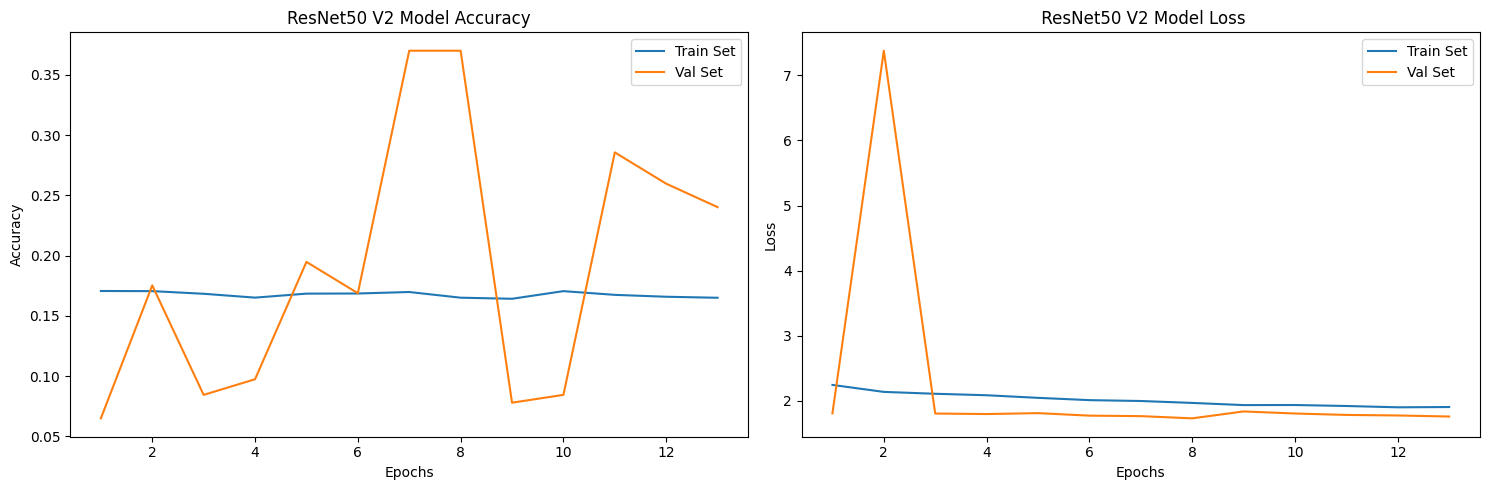

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet50 V2 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' ResNet50 V2 Model Loss')

plt.tight_layout()
plt.show()

In [27]:
#  we will load the best weights of the model with minimum validation loss and maximum validation accuracy so that we can evaluate the performance of the model on various performance metrics.
from keras.models import load_model
model = load_model('.mdl1_wts.hdf5')
#checking the score of the model
score=model.evaluate(val_data)
print(score)

10/10 [==============================] - 4s 268ms/step - loss: 1.7654 - accuracy: 0.3701
[1.7653940916061401, 0.37012988328933716]


model performed moderately well on test data with an overall validation accuracy of ---%. But now we will evaluate it on completely unseen test data so that we can assess its performance in a real sense

In [28]:
# checking the accuracy on test data
accuracy = model.evaluate(test_data, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

4/4 [==============================] - 1s 273ms/step - loss: 1.7872 - accuracy: 0.3016

 Test_Accuracy:- 0.30158731341362


Confusion Matrix

4/4 [==============================] - 2s 271ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         7
           2       0.50      0.13      0.21        15
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         6
           5       0.30      0.94      0.46        18

    accuracy                           0.30        63
   macro avg       0.13      0.18      0.11        63
weighted avg       0.21      0.30      0.18        63



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



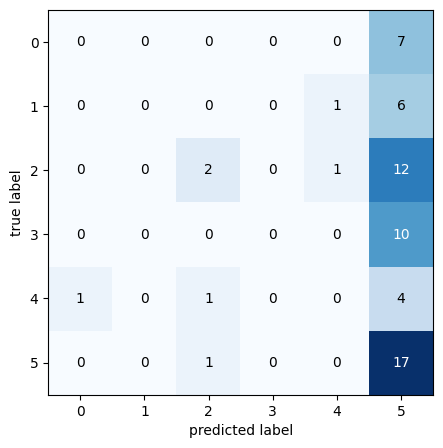

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict classes for the test data
y_pred = model.predict(test_data)

# Get the true labels from the test data generator
y_true = test_data.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

print('{}'.format(classification_report(y_true , y_pred_labels)))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = conf_matrix, figsize = (5,5))
plt.show()

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc = accuracy_score(true_classes, y_pred_labels)
print("ResNet50-based Model Accuracy: {:.2f}%".format(acc * 100))

print('Precision: %.3f' % precision_score(true_classes, y_pred_labels,average='macro'))
print('Recall: %.3f' % recall_score(true_classes, y_pred_labels,average='macro'))
print('F1 Score: %.3f' % f1_score(true_classes, y_pred_labels,average='macro'))

ResNet50-based Model Accuracy: 30.16%
Precision: 0.134
Recall: 0.180
F1 Score: 0.112


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Model 2: MobileNet V2



In [31]:
checkpoint = ModelCheckpoint('.mdl2_wts.hdf5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                                   verbose=1, mode='min', min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)


callbacks = [checkpoint,reduce_lr, early_stopping]

In [32]:
conv_base = MobileNetV2(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True


x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(6, activation='softmax')(x)
model = Model(conv_base.input, predictions)

# Define the optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model.fit(resampled_datagen,batch_size=BATCH_SIZE,callbacks=callbacks, validation_data=val_data,epochs=20,verbose=1)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/20
557/557 [==============================] - ETA: 0s - loss: 2.0813 - accuracy: 0.1626
Epoch 1: val_accuracy improved from -inf to 0.12987, saving model to .mdl2_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



557/557 [==============================] - 353s 612ms/step - loss: 2.0813 - accuracy: 0.1626 - val_loss: 1.7186 - val_accuracy: 0.1299 - lr: 0.0010
Epoch 2/20
557/557 [==============================] - ETA: 0s - loss: 1.8506 - accuracy: 0.1646
Epoch 2: val_accuracy improved from 0.12987 to 0.14935, saving model to .mdl2_wts.hdf5
557/557 [==============================] - 340s 610ms/step - loss: 1.8506 - accuracy: 0.1646 - val_loss: 1.7860 - val_accuracy: 0.1494 - lr: 0.0010
Epoch 3/20
557/557 [==============================] - ETA: 0s - loss: 1.8119 - accuracy: 0.1569
Epoch 3: val_accuracy improved from 0.14935 to 0.25325, saving model to .mdl2_wts.hdf5

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
557/557 [==============================] - 339s 608ms/step - loss: 1.8119 - accuracy: 0.1569 - val_loss: 1.7757 - val_accuracy: 0.2532 - lr: 0.0010
Epoch 4/20
557/557 [==============================] - ETA: 0s - loss: 1.7979 - accuracy: 0.1617
Epoch 4: val_accu

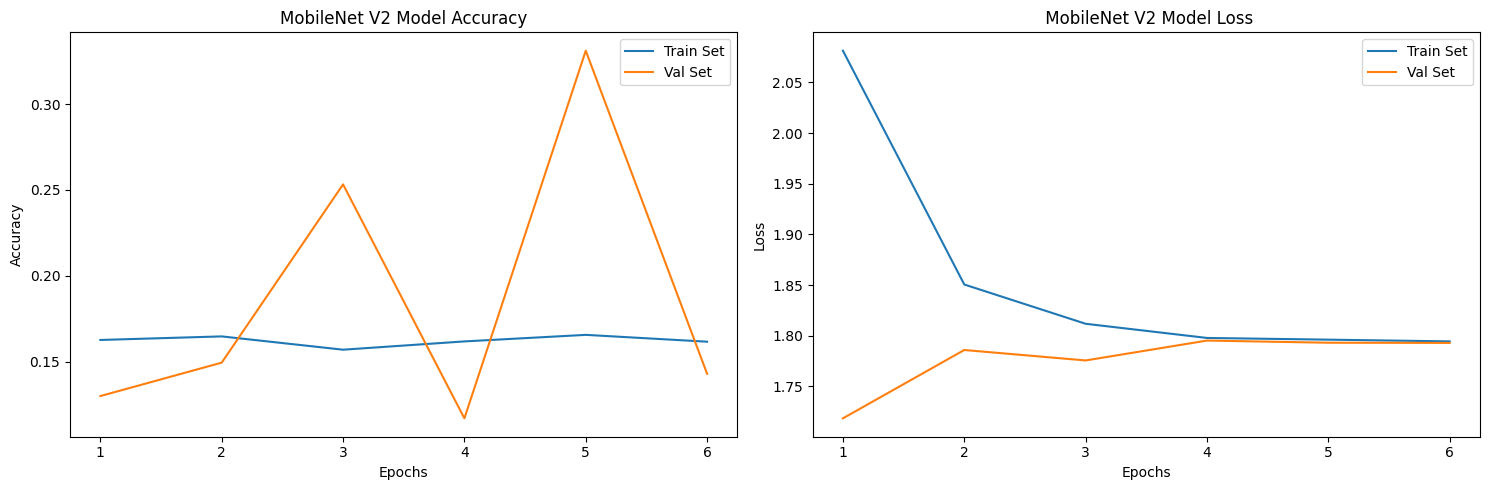

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNet V2 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' MobileNet V2 Model Loss')

plt.tight_layout()
plt.show()

In [34]:
#  we will load the best weights of the model with minimum validation loss and maximum validation accuracy so that we can evaluate the performance of the model on various performance metrics.
from keras.models import load_model
model = load_model('.mdl2_wts.hdf5')
#checking the score of the model
score=model.evaluate(val_data)
print(score)

10/10 [==============================] - 2s 75ms/step - loss: 1.7932 - accuracy: 0.3312
[1.7931674718856812, 0.3311688303947449]


In [35]:
# checking the accuracy on test data
accuracy = model.evaluate(test_data, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

4/4 [==============================] - 0s 78ms/step - loss: 1.7932 - accuracy: 0.3175

 Test_Accuracy:- 0.3174603283405304


4/4 [==============================] - 1s 72ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.25      0.14      0.18         7
           2       0.30      0.20      0.24        15
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         6
           5       0.33      0.89      0.48        18

    accuracy                           0.32        63
   macro avg       0.15      0.21      0.15        63
weighted avg       0.19      0.32      0.21        63



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



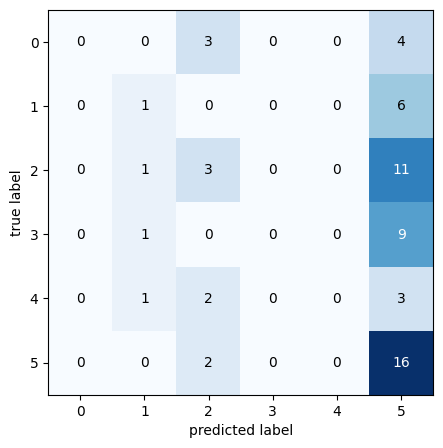

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict classes for the test data
y_pred = model.predict(test_data)

# Get the true labels from the test data generator
y_true = test_data.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

print('{}'.format(classification_report(y_true , y_pred_labels)))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = conf_matrix, figsize = (5,5))
plt.show()

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc = accuracy_score(true_classes, y_pred_labels)
print("MobileNet-based Model Accuracy: {:.2f}%".format(acc * 100))

print('Precision: %.3f' % precision_score(true_classes, y_pred_labels,average='macro'))
print('Recall: %.3f' % recall_score(true_classes, y_pred_labels,average='macro'))
print('F1 Score: %.3f' % f1_score(true_classes, y_pred_labels,average='macro'))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



MobileNet-based Model Accuracy: 31.75%
Precision: 0.146
Recall: 0.205
F1 Score: 0.150


### Model 3 : DenseNet121


In [38]:
checkpoint = ModelCheckpoint('.mdl3_wts.hdf5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                                   verbose=1, mode='min', min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)


callbacks = [checkpoint,reduce_lr, early_stopping]

In [39]:
from tensorflow.keras.applications import DenseNet121

# Load the DenseNet121 model pretrained on ImageNet data
conv_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Allow fine-tuning of the whole model
conv_base.trainable = True

# Add custom layers on top of the base model
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)
model = Model(inputs=conv_base.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])


# Train the model
history = model.fit(resampled_datagen, batch_size=BATCH_SIZE, callbacks=callbacks, validation_data=val_data, epochs=20, verbose=1)


29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/20
557/557 [==============================] - ETA: 0s - loss: 1.3009 - accuracy: 0.5233
Epoch 1: val_accuracy improved from -inf to 0.17532, saving model to .mdl3_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



557/557 [==============================] - 1086s 2s/step - loss: 1.3009 - accuracy: 0.5233 - val_loss: 2.0143 - val_accuracy: 0.1753 - lr: 1.0000e-04
Epoch 2/20
557/557 [==============================] - ETA: 0s - loss: 0.4389 - accuracy: 0.8647
Epoch 2: val_accuracy improved from 0.17532 to 0.21429, saving model to .mdl3_wts.hdf5
557/557 [==============================] - 1057s 2s/step - loss: 0.4389 - accuracy: 0.8647 - val_loss: 1.8312 - val_accuracy: 0.2143 - lr: 1.0000e-04
Epoch 3/20
557/557 [==============================] - ETA: 0s - loss: 0.2956 - accuracy: 0.9114
Epoch 3: val_accuracy did not improve from 0.21429
557/557 [==============================] - 1055s 2s/step - loss: 0.2956 - accuracy: 0.9114 - val_loss: 2.1598 - val_accuracy: 0.1753 - lr: 1.0000e-04
Epoch 4/20
557/557 [==============================] - ETA: 0s - loss: 0.2521 - accuracy: 0.9255
Epoch 4: val_accuracy did not improve from 0.21429

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-

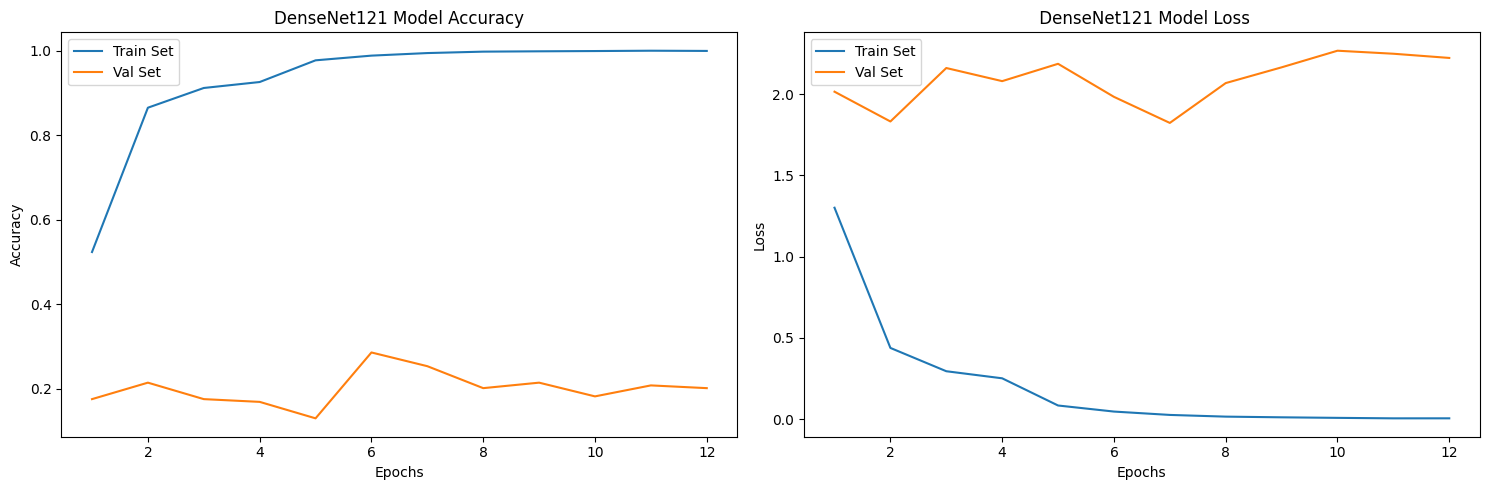

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('DenseNet121 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' DenseNet121 Model Loss')

plt.tight_layout()
plt.show()

In [41]:
#  we will load the best weights of the model with minimum validation loss and maximum validation accuracy so that we can evaluate the performance of the model on various performance metrics.
from keras.models import load_model
model = load_model('.mdl3_wts.hdf5')
#checking the score of the model
score=model.evaluate(val_data)
print(score)

10/10 [==============================] - 4s 254ms/step - loss: 1.9826 - accuracy: 0.2857
[1.9826031923294067, 0.2857142984867096]


In [42]:
# checking the accuracy on test data
accuracy = model.evaluate(test_data, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

4/4 [==============================] - 1s 266ms/step - loss: 2.2868 - accuracy: 0.2381

 Test_Accuracy:- 0.2380952388048172


4/4 [==============================] - 3s 308ms/step
              precision    recall  f1-score   support

           0       0.14      0.14      0.14         7
           1       0.14      0.14      0.14         7
           2       0.27      0.40      0.32        15
           3       0.29      0.60      0.39        10
           4       0.00      0.00      0.00         6
           5       0.20      0.06      0.09        18

    accuracy                           0.24        63
   macro avg       0.17      0.22      0.18        63
weighted avg       0.20      0.24      0.20        63



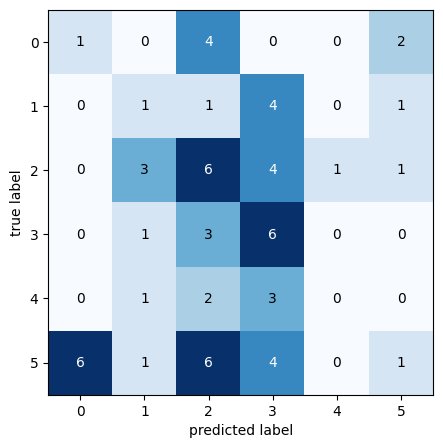

In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict classes for the test data
y_pred = model.predict(test_data)

# Get the true labels from the test data generator
y_true = test_data.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

print('{}'.format(classification_report(y_true , y_pred_labels)))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = conf_matrix, figsize = (5,5))
plt.show()

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc = accuracy_score(true_classes, y_pred_labels)
print("DenseNet121-based Model Accuracy: {:.2f}%".format(acc * 100))

print('Precision: %.3f' % precision_score(true_classes, y_pred_labels,average='macro'))
print('Recall: %.3f' % recall_score(true_classes, y_pred_labels,average='macro'))
print('F1 Score: %.3f' % f1_score(true_classes, y_pred_labels,average='macro'))

DenseNet121-based Model Accuracy: 23.81%
Precision: 0.174
Recall: 0.224
F1 Score: 0.181
